# Final Project: Toxic Chat Classification Using NLP

## Introduction
In this project, we will be using Natural Language Processing (NLP) to classify toxic comments in a chat. The dataset we will be using is the 
1. ) [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) dataset from Kaggle. The dataset consists of comments from Wikipedia’s talk page edits. The comments are labeled as toxic, severe toxic, obscene, threat, insult, and identity hate. The goal of this project is to build a model that can classify the comments into these categories.
2. ) [Sensai] is a toxic chat dataset consists of live chats from Virtual YouTubers' live streams
   curl -L -o ~/Downloads/archive.zip\ https://www.kaggle.com/api/v1/datasets/download/uetchy/sensai
3. ) [The Toxicity Dataset] This repo contains 500 toxic and 500 non-toxic comments from a variety of popular social media platforms. https://github.com/surge-ai/toxicity

## Members
1. ) HTUN HTET MYAT (BLAKE)
2. ) CHE TAIFU
3. ) MA YONGQIANG
4. ) TANG JIRUI
5. ) ZHANG DAPENG

## Task List and Allocations
1. ) Project Scope and Idea - Proposed by Blake, Agreed by all
2. ) Data Sourcing - Blake
3. ) Data Cleaning - ZHANG DAPENG, Blake
4. ) Data PreProcessing - Blake
5. ) Model Building LSTM (Binary & Multiple)Classifiers - Blake
6. ) Model Evaluation LSTM (Binary & Multiple)Classifiers - Blake
7. ) Model Building BERT - CHE TAIFU
8. ) Model Evaluation BERT - CHE TAIFU
9. ) Another Model - MA YONGQIANG
10. ) Another Model Evaluation - MA YONGQIANG
11. ) Compiling and Putting All Saved Models together - TANG JIRUI
12. ) UI Building & Model Texts - TANG JIRUI
13. ) UI Presentation - TANG JIRUI
14. ) Video Building - ZHANG DAPENG
15. ) Video Presentation - ALL


USE SMOTE for Data Splitting

In [50]:
# Import Statements 
import os
import re
import requests
import nltk
import string
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, Dataset
# import sentencepiece
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
# from symspellpy import SymSpell, Verbosity
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet
import tensorflow as tf

[nltk_data] Downloading package wordnet to /Users/blake/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/blake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/blake/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [51]:
import tensorflow as tf
# List physical devices
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

# List GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)
else:
    print("No GPU detected.")


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU detected.


In [52]:
# Default Functions to clean the NLP Dataset, remove stopwords, lemmatize, and stem the words
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def tagged_lemma(string):
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


def clean_string(text, stem="None"):

    # Final String to return
    final_string = ""

    # Make the text to be lower case
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', ' ', text)

    # Remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [53]:
# Start with Cleaning the Data of Kaggle Toxic Comment Dataset

df_kaggle = pd.read_csv('./data/kaggle-toxic-comment-challange/kaggle_train.csv')
## Pretty print alll the dataframes columns
print(df_kaggle.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [54]:
def remove_duplicates(df, text_column):
    df_cleaned = df.drop_duplicates(subset=[text_column], keep='first').reset_index(drop=True)
    return df_cleaned

df_kaggle_cleaned = remove_duplicates(df_kaggle, 'comment_text')


In [55]:
df_kaggle_cleaned = df_kaggle_cleaned.rename(columns={'comment_text':'comments'})
print(df_kaggle_cleaned.columns)

Index(['id', 'comments', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [56]:
# merge
df_kaggle_cleaned = remove_duplicates(df_kaggle_cleaned, 'comments')
df_kaggle_cleaned['text_cleaned'] = df_kaggle_cleaned['comments'].apply(lambda x: clean_string(x, stem="Lem"))

#Create a new column called any_toxic for data spltting purposes and to know if any of the lable is true.
df_kaggle_cleaned['any_toxic'] = df_kaggle_cleaned[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].apply(lambda x: 1 if x.sum() > 0 else 0, axis=1)
df_kaggle_cleaned.to_csv('./data/kaggle_toxicity_data_cleaned.csv', index=False)

In [58]:
#Skipp all to read the cleaned data
df_kaggle_cleaned = pd.read_csv('./data/kaggle_toxicity_data_cleaned.csv')

In [59]:
# Get possible lables values for the dataset
print(df_kaggle_cleaned['toxic'].unique())
print(df_kaggle_cleaned['severe_toxic'].unique())
print(df_kaggle_cleaned['obscene'].unique())
print(df_kaggle_cleaned['threat'].unique())
print(df_kaggle_cleaned['insult'].unique())
print(df_kaggle_cleaned['identity_hate'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


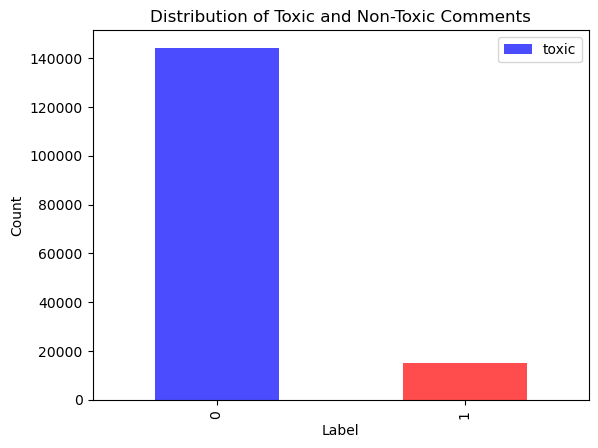

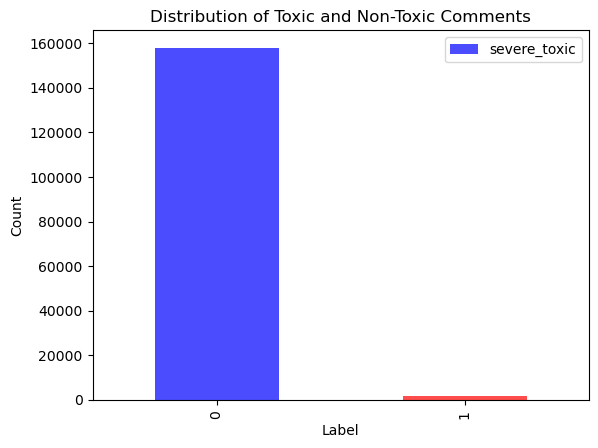

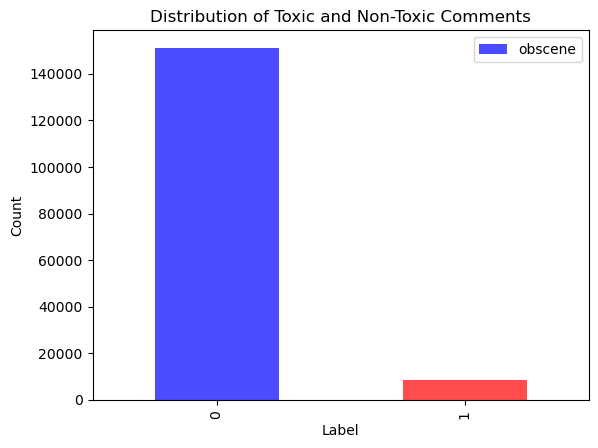

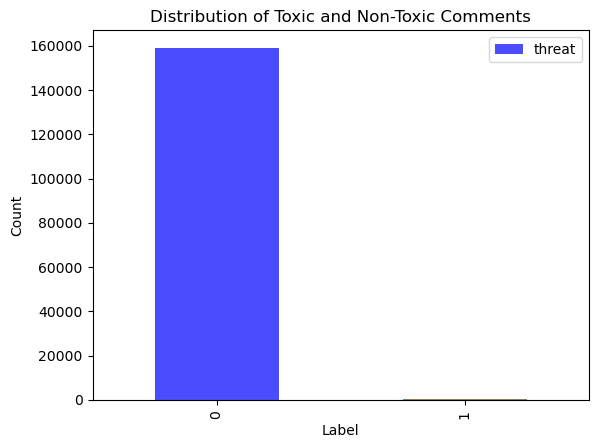

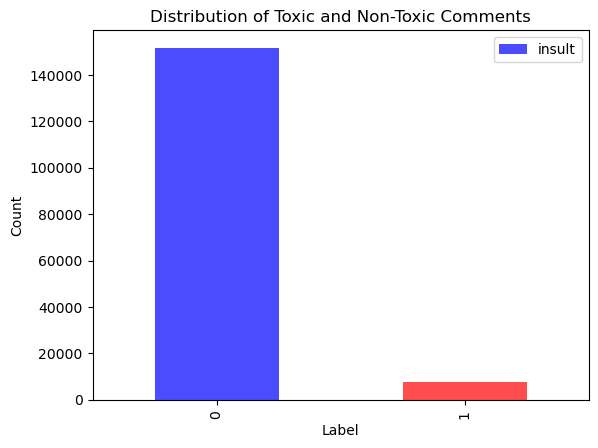

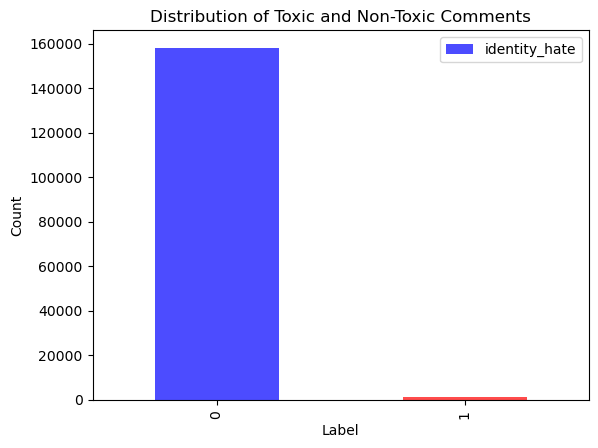

In [60]:
# Find the count of toxic and non-toxic comments
# Print the data distributions of different columns counts
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for column in columns:
    # Combine all distributions into one plot
    df_kaggle_cleaned[column].value_counts().plot(kind='bar', color=['blue', 'red'], alpha=0.7, label=column)
    plt.legend()
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Toxic and Non-Toxic Comments')
    plt.show()

### now we see the distribution of the comments is very skewed . Need to balance the dataset

In [ ]:
# Split the data into train and test sets with smote+enn to ensure balance
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split

df_kaggle_cleaned['stratify_col'] = df_kaggle_cleaned[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
label_counts = df_kaggle_cleaned['stratify_col'].value_counts()
rare_labels = label_counts[label_counts < 2].index
print(rare_labels)
# Remove rare labels from the dataset
df_kaggle_cleaned = df_kaggle_cleaned[~df_kaggle_cleaned['stratify_col'].isin(rare_labels)]

training_set , test_set = train_test_split(df_kaggle_cleaned, test_size=0.2, stratify=df_kaggle_cleaned['stratify_col'], random_state=42)

Index(['1_1_0_1_1_0', '1_1_0_1_0_1'], dtype='object', name='stratify_col')


In [80]:
training_set['text_cleaned'] = training_set['text_cleaned'].fillna('').astype(str)
test_set['text_cleaned'] = test_set['text_cleaned'].fillna('').astype(str)

In [81]:
# To Create Vectors for Textual Data use the log term frequencey to reduce the weight of common words
# ngram to be 3
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization (
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    pad_to_max_tokens=True
)
encoder.adapt(training_set['text_cleaned'].tolist())

In [82]:

lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64), #Replacing the simple RNN with a LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])


In [83]:
lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5),
              metrics=['accuracy'])

In [84]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

historyLSTM = lstm.fit(training_set['text_cleaned'],training_set[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], epochs=10,
                    validation_data=(test_set['text_cleaned'],test_set[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]),
                    batch_size=64,
                    validation_steps=30)
lstm.save('./models/lstm_model_multipleclassifier.keras')

Epoch 1/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 206s 103ms/step - accuracy: 0.8483 - loss: 0.2673 - val_accuracy: 0.9917 - val_loss: 0.1113
Epoch 2/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 205s 103ms/step - accuracy: 0.9939 - loss: 0.0951 - val_accuracy: 0.9932 - val_loss: 0.0707
Epoch 3/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 204s 102ms/step - accuracy: 0.9942 - loss: 0.0630 - val_accuracy: 0.9958 - val_loss: 0.0568
Epoch 4/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 205s 103ms/step - accuracy: 0.9941 - loss: 0.0548 - val_accuracy: 0.9948 - val_loss: 0.0594
Epoch 5/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 205s 103ms/step - accuracy: 0.9939 - loss: 0.0512 - val_accuracy: 0.9948 - val_loss: 0.0652
Epoch 6/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 205s 103ms/step - accuracy: 0.9939 - loss: 0.0476 - val_accuracy: 0.9937 - val_loss: 0.0519
Epoch 7/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 205s 103ms/step - accuracy: 0.9945 - loss: 0.0459 - val_accuracy: 0.9943 - val_loss: 0.0557
Epoch 8/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 208s 104ms/step - ac

In [85]:
lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_4            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,032,724 (7.75 MB)

 Trainable params: 677,574 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,355,150 (5.17 MB)

In [86]:
pred = lstm.predict(test_set['text_cleaned'])
pred = np.round(pred).astype(int)

998/998 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


In [87]:
np.unique(pred)

array([0, 1])

In [89]:
pred_flat = np.round(pred).astype(int).flatten()
print(f"Shape of predictions: {pred_flat.shape}")
print(f"Shape of true labels: {test_set[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].shape}")

Shape of predictions: (191484,)
Shape of true labels: (31914, 6)


Confusion Matrix for toxic:
[[28316   539]
 [  779  2280]]
Classification Report for toxic:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     28855
           1       0.81      0.75      0.78      3059

    accuracy                           0.96     31914
   macro avg       0.89      0.86      0.88     31914
weighted avg       0.96      0.96      0.96     31914



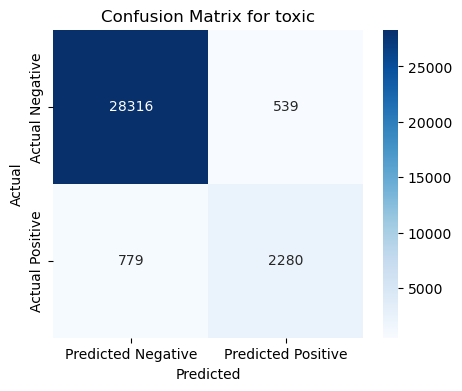

Confusion Matrix for severe_toxic:
[[31538    57]
 [  256    63]]
Classification Report for severe_toxic:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31595
           1       0.53      0.20      0.29       319

    accuracy                           0.99     31914
   macro avg       0.76      0.60      0.64     31914
weighted avg       0.99      0.99      0.99     31914



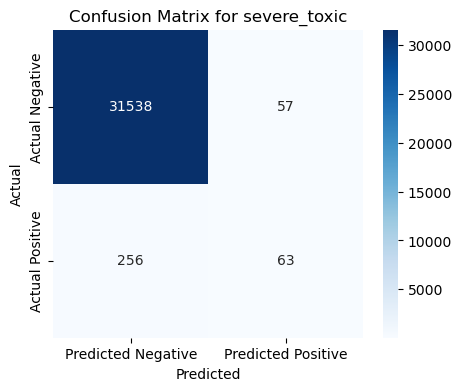

Confusion Matrix for obscene:
[[29864   360]
 [  354  1336]]
Classification Report for obscene:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     30224
           1       0.79      0.79      0.79      1690

    accuracy                           0.98     31914
   macro avg       0.89      0.89      0.89     31914
weighted avg       0.98      0.98      0.98     31914



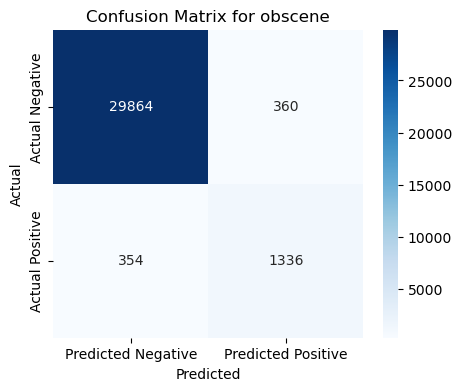

Confusion Matrix for threat:
[[31820     0]
 [   94     0]]
Classification Report for threat:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31820
           1       0.00      0.00      0.00        94

    accuracy                           1.00     31914
   macro avg       0.50      0.50      0.50     31914
weighted avg       0.99      1.00      1.00     31914



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


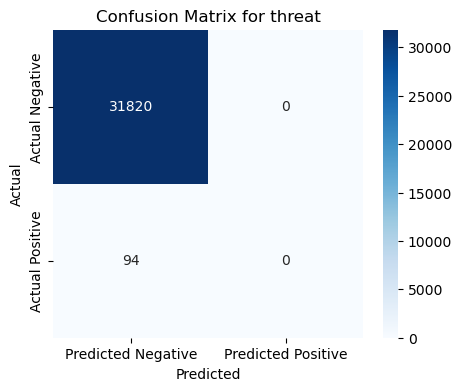

Confusion Matrix for insult:
[[29854   484]
 [  446  1130]]
Classification Report for insult:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     30338
           1       0.70      0.72      0.71      1576

    accuracy                           0.97     31914
   macro avg       0.84      0.85      0.85     31914
weighted avg       0.97      0.97      0.97     31914



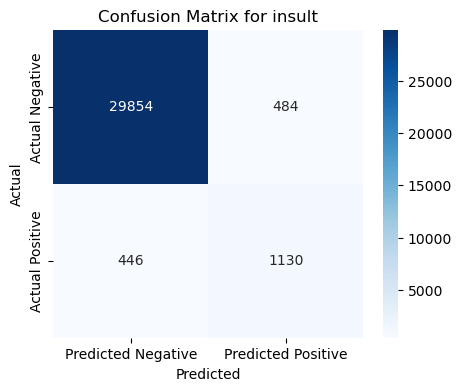

Confusion Matrix for identity_hate:
[[31632     0]
 [  282     0]]
Classification Report for identity_hate:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31632
           1       0.00      0.00      0.00       282

    accuracy                           0.99     31914
   macro avg       0.50      0.50      0.50     31914
weighted avg       0.98      0.99      0.99     31914



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


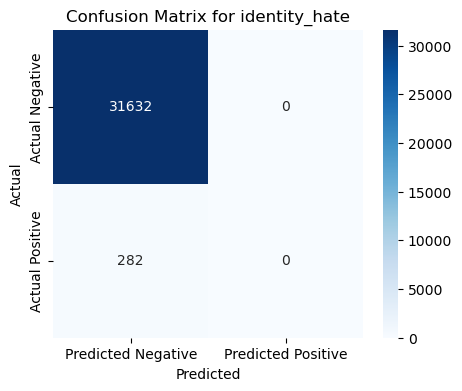

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the label columns
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Ensure predictions are in the same format as test_set labels
pred_flat = np.array(pred)  # Convert predictions to a numpy array if necessary
y_test = test_set[label_columns].values  # Convert test labels to numpy array

# Loop through each label and compute the confusion matrix
for i, label in enumerate(label_columns):
    cm = confusion_matrix(y_test[:, i], pred_flat[:, i])
    
    # Print confusion matrix for each label
    print(f"Confusion Matrix for {label}:")
    print(cm)
    
    # Print classification report for each label
    print(f"Classification Report for {label}:")
    print(classification_report(y_test[:, i], pred_flat[:, i]))

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()


In [92]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [93]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

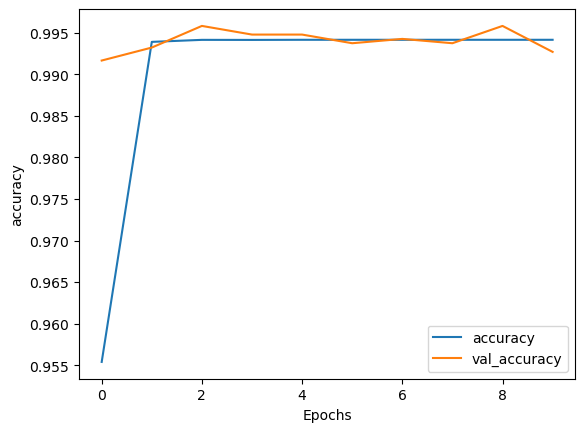

In [94]:
plot_graphs(historyLSTM, "accuracy")

In [ ]:
# Load the model
model_path = './models/lstm_model_multipleclassifier.keras'
lstm_sigmoid = tf.keras.models.load_model(model_path)

# Define the prediction function
def predict_text(text, model,threshold=0.5):
    # Clean the text    
    # Convert to TensorFlow tensor with dtype=tf.string
    input_text = tf.constant(text, dtype=tf.string)
    # Make prediction
    prediction = model.predict(input_text)
    
     # Convert probabilities to binary predictions using the threshold
    binary_prediction = (prediction >= threshold).astype(int)
    
    # Map binary predictions to labels
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    predicted_labels = []
    for i, label in enumerate(label_columns):
        if binary_prediction[0][i] == 1:  # Check if the label is predicted as positive
            predicted_labels.append(label)
    
    # Return the list of predicted labels
    return predicted_labels



In [111]:
# Reusults of the model in terms of
model1_path = './models/lstm_model_multipleclassifier.keras'
lstm = tf.keras.models.load_model(model1_path)

test_1 = [
    "cunt.",
    "cunk.",
    "I hope you go kill yourself.",
    "I hope you go un-alive yourself and go to heaven",
    "I'd call you dumb as a rock, but at least a rock can hold a door open...",
    "You’re impossible to underestimate.",
    "I bet your parents change the subject when their friends ask about you.",
    "I envy the people who havent met you",
    "You’re a conversation starter. Not when you are around but once you leave",
    "If you were the light at the end of the tunnel, I’d turn back around",
    "I'd give you a nasty look but you've already got one",
    "I'm genuinely excited to never interact with you again.",
    "If I throw a stick, will you leave?",
    "Everyone who ever loved you was wrong.",
]
test_1 = [string.lower() for string in test_1]

for text in test_1:
    predicted_label1 = predict_text([text], lstm_sigmoid,0.4)
    print(predicted_label1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
['toxic', 'obscene', 'insult']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
['toxic', 'obscene', 'insult']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
['toxic']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
['toxic', 'obscene', 'insult']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
['toxic']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
['toxic']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[]


['toxic', 'obscene', 'insult']